<a href="https://colab.research.google.com/github/clrzr/xai-fraud/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the easiest way to replicate this project. But you need a GCP colab instance. Go figure!

All the files you need should be in the "files I need folder"

Files I Need

https://drive.google.com/drive/folders/1SeV3Z9facwuAmCb9WzT-xkBIH4YKlOeG?usp=drive_link

In [ ]:
#copy the 100.hDataFrame5-20240525T124001Z-001.zip file into the root folder then run this

!unzip -o "/100.hDataFrame5-20240525T124001Z-001.zip" -d "/" #Extract the ML checkpoint ZIP file

Archive:  /100.hDataFrame5-20240525T124001Z-001.zip
   creating: /100.hDataFrame5/assets/
  inflating: /100.hDataFrame5/fingerprint.pb  
  inflating: /100.hDataFrame5/saved_model.pb  
  inflating: /100.hDataFrame5/keras_metadata.pb  
  inflating: /100.hDataFrame5/variables/variables.data-00000-of-00001  
  inflating: /100.hDataFrame5/variables/variables.index  


# Load Dependencies

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats

import tensorflow as tf

import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# 1. Load data


In [ ]:
DataFrame_0 = pd.read_csv("/data_Preprocessing_month_hist_encode_standarize.csv")
DataFrame_0=DataFrame_0.drop(columns=['Latitude','Longitude','hist_fraud_trans_24h'])
DataFrame2=DataFrame_0
cnt_non_fraud = DataFrame2[DataFrame2['Fraud'] ==0]['Amount'].count()
DataFrame2_class_fraud = DataFrame2[DataFrame2['Fraud'] == 1]
DataFrame2_class_nonfraud = DataFrame2[DataFrame2['Fraud'] == 0]
#OverSampling
DataFrame2_class_fraud_oversample = DataFrame2_class_fraud.sample(cnt_non_fraud, replace=True)
DataFrame2_oversampled = pd.concat([DataFrame2_class_nonfraud, DataFrame2_class_fraud_oversample], axis=0)
DataFrame=DataFrame2_oversampled

In [ ]:
from imblearn.over_sampling import SMOTE
X=DataFrame.drop(columns=['Fraud'])
Y=DataFrame[['Fraud']]
X_train, X_test, Y_train, Y_Test = train_test_split(X, Y, test_size = 0.30,random_state = 101)
X_train=X_train.drop(columns=['index'])
X_Train, Y_Train=SMOTE(random_state=42).fit_resample(X_train, Y_train)

Define the model

In [ ]:
input_layer = Input(shape=(X_Train.shape[1],))
encoded = Dense(22, activation='relu')(input_layer)
encoded = Dense(15, activation='relu')(encoded)
decoded = Dense(10, activation='relu')(encoded)
decoded = Dense(5, activation='relu')(decoded)
output_layer = Dense(2, activation='softmax')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='Adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# 2. Train model



Don't run this if you want to skip training an use the checkpoint instead

In [ ]:
nb_epoch = 100
batch_size = 32

# save most accurate checkpoint
filepath="/content/drive/My Drive/Colab Notebooks/Model/temp/{epoch:01d}.hDataFrame5"
checkpointer = ModelCheckpoint(filepath,verbose=1,save_best_only=True,monitor='accuracy')
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_Train, Y_Train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    # validation_data=(X_test, X_test),
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

#Zip Accurate Checkpoints
!zip -r "/content/drive/My Drive/Colab Notebooks/Model/result_DNN.zip" "/content/drive/My Drive/Colab Notebooks/Model/temp" || echo "Zip command failed"

# Load Checkpoint w/o retraining Model (to use this skip 2)

In [ ]:
autoencoder = load_model("/100.hDataFrame5")

# Model Evaluation

In [ ]:
# Grid search on n_estimators

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

param_test1 = {'n_estimators':[50,120,160,200,250]}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10),
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X_Train,Y_Train)
print(gsearch1.best_params_, gsearch1.best_score_)  #print the fitting results.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators= 120, max_depth=13,max_features=3,oob_score=True, random_state=10)
rfc.fit(X_Train, Y_Train)

#predictions
yPred = rfc.predict(X_test.drop(columns=['index']))
#building all kinds of evaluating parameters

yTest = Y_Test


acc = accuracy_score(yTest, yPred)
print("The accuracy is {}".format(acc))

prec = precision_score(yTest, yPred)
print("The precision is {}".format(prec))

rec = recall_score(yTest, yPred)
print("The recall is {}".format(rec))

f1 = f1_score(yTest, yPred)
print("The F1-Score is {}".format(f1))

MCC = matthews_corrcoef(yTest, yPred)
print("The Matthews correlation coefficient is{}".format(MCC))


# Implement XAI Method (SHAP)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.6 MB/s eta 0:00:00


Load Data

In [ ]:
DataFrame_encoder=pd.read_csv("/data_Preprocessing_month_hist_encode.csv").drop(columns=['Fraud','index','Latitude','Longitude','hist_fraud_trans_24h'])
DataFrame_encoder

,Amount,Use Chip,Errors,Trans_hour,Day_of_week,MCC_Category,Current Age,Gender,hist_trans_60d,hist_trans_24h,hist_trans_avg_amt_60d
0,89.54,0,0,6,3,0,53,0,0.0,0.0,0.000000
1,65.82,0,0,21,3,1,53,0,0.0,1.0,0.000000
2,43.42,0,0,6,4,0,53,0,2.0,2.0,77.680000
3,136.58,0,0,13,5,2,53,0,3.0,2.0,66.260000
4,82.05,0,0,13,5,0,53,0,3.0,1.0,66.260000
...,...,...,...,...,...,...,...,...,...,...,...
68471,149.39,0,0,16,5,8,47,0,147.0,3.0,42.185405
68472,30.55,0,0,18,5,1,47,0,147.0,3.0,42.185405
68473,14.59,0,0,19,5,1,47,0,147.0,4.0,42.185405
68474,32.47,0,0,19,6,1,47,0,151.0,4.0,42.635563


# 3. Compute Global SHAP values

In [ ]:
import shap

In [ ]:
#n can be set to as high as 68,475
DataFrame_features = X_Train.sample(n=6000, random_state=1)
def g(record):
    return autoencoder.predict(record)[:, 1]  # Predict using the autoencoder

Skip this if loading computed SHAP values

In [ ]:
#This block will compute SHAP values using a 6,000 randomly selected rows, as set by 'n' above.
#This is about 9% of the X_Train dataset but, takes ~5hrs to compute on a GCP e2-standard-8 instance

# Sample data for SHAP calculation
MedianInput = DataFrame_features.median().values.reshape((1, DataFrame_features.shape[1]))
nn_explainer_2 = shap.Explainer(g, MedianInput)

# Calculate SHAP values
shap_values_nn = nn_explainer_2(DataFrame_features)

# Save shap_values_nn
with open("/shap_values_nn.pkl", 'wb') as f:
    pickle.dump(shap_values_nn, f)

# 4. Load Pre-computed SHAP Values

In [ ]:
# Load shap_values_nn (when resuming work)
import pickle
with open("/shap_values_nn.pkl", 'rb') as f:
    shap_values_nn = pickle.load(f)

Gloabal SHAP values Beeswarm Plot

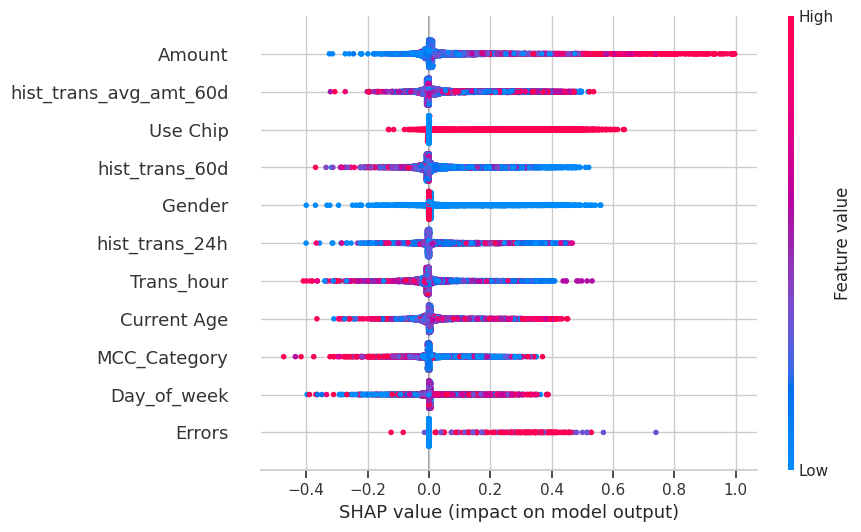

In [ ]:
shap.initjs()
shap.plots.beeswarm(shap_values_nn, max_display=11)

Gloabal SHAP values Force Plot

In [ ]:
shap.initjs()
shap.force_plot(shap_values_nn[0], feature_names=X_Train.columns, show=True)

Gloabal SHAP values Bar Plot

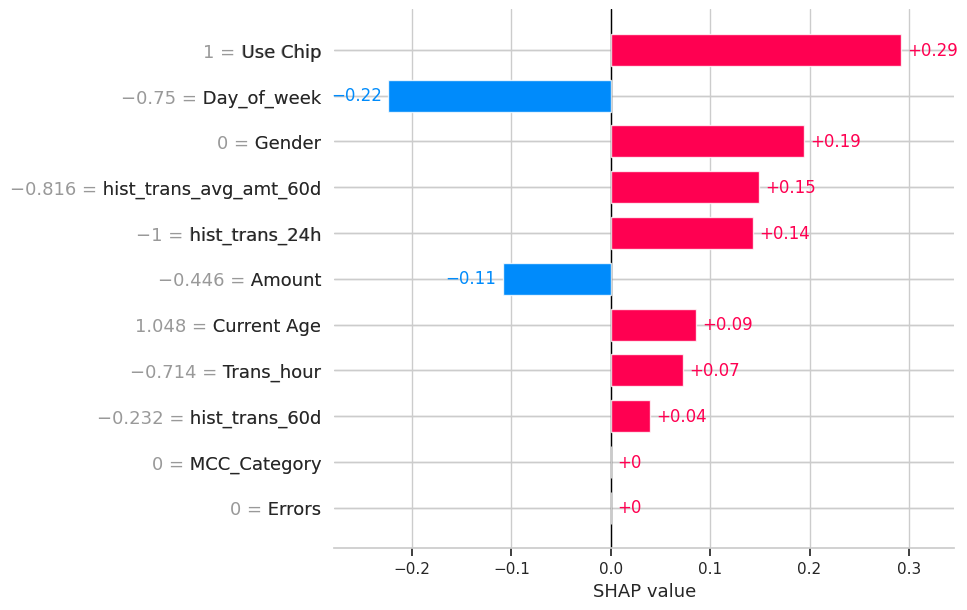

In [ ]:
shap.initjs()
shap.plots.bar(shap_values_nn[0], max_display=11)

Decision Plot for a Local Shap value of a particular data point. (Skip this if your goal is to use the webapp)

1/1 [==============================] - 0s 138ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


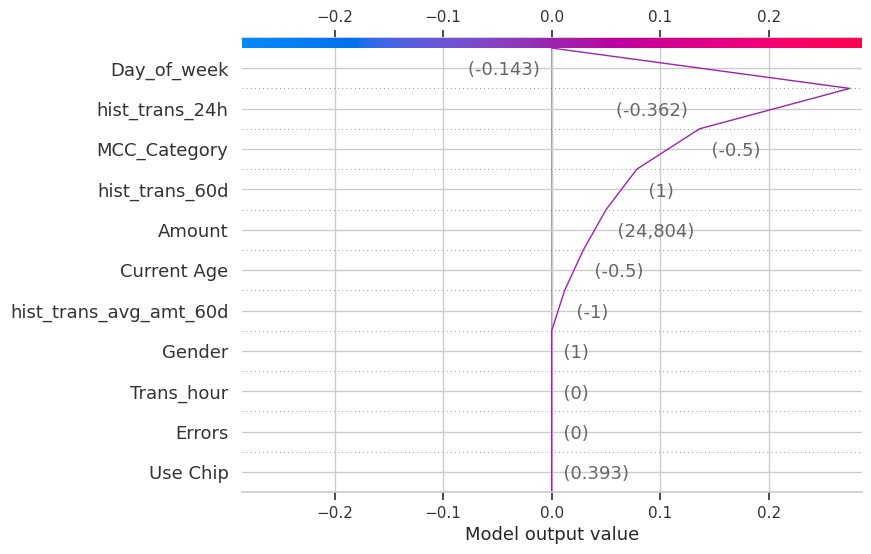

In [ ]:
import shap
import matplotlib.pyplot as plt

def g(record):
    return autoencoder.predict(record)[:, 1]

# Sample background data (optional for decision plot, but useful for reference)
DataFrame_features = X_Train.sample(n=6000, random_state=1)
MedianInput = DataFrame_features.median().values.reshape((1, DataFrame_features.shape[1]))

# Choose a specific instance you want to explain

#instance_index = 30 disrupts the labeling of SHAP instances in the webapp. Not enough time to debug so SKIP if your goal is to use the webapp

instance_index = 30  # Replace with the actual index you want to analyze
instance_to_explain = X_test.iloc[[instance_index]]
instance_to_explain_reshaped = instance_to_explain.iloc[:, 1:].values.reshape((1, 11))

# SHAP explainer (using KernelExplainer for a model-agnostic explanation)
explainer = shap.KernelExplainer(g, MedianInput)

# Calculate SHAP values for the chosen instance
shap_values = explainer.shap_values(instance_to_explain_reshaped)

# Generate SHAP decision plot
shap.decision_plot(
    explainer.expected_value,
    shap_values,
    instance_to_explain,
    feature_names=list(X_Train.columns),    # Change to a list
    show=True
)

# Plot SHAP decision plots for 5 identified fraudulent transcations

You can skip all below till implementing LLM


1/1 [==============================] - 0s 72ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


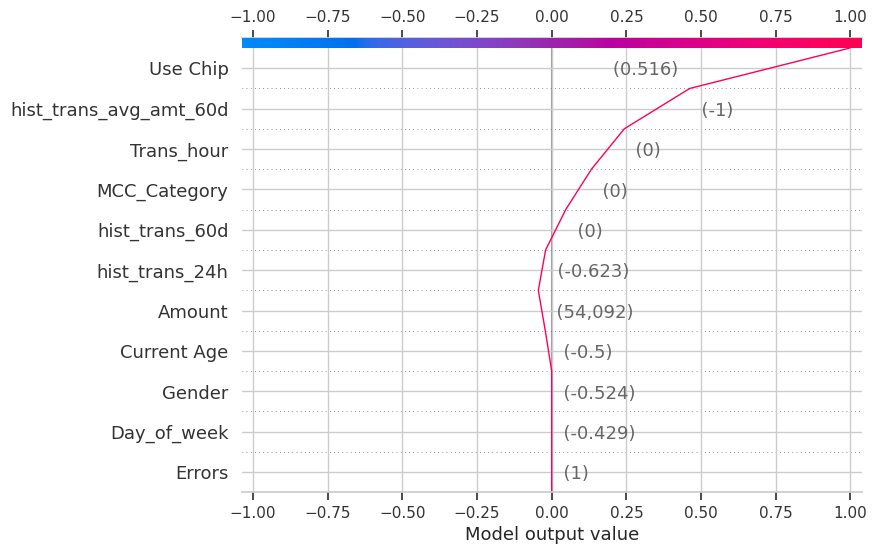

  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


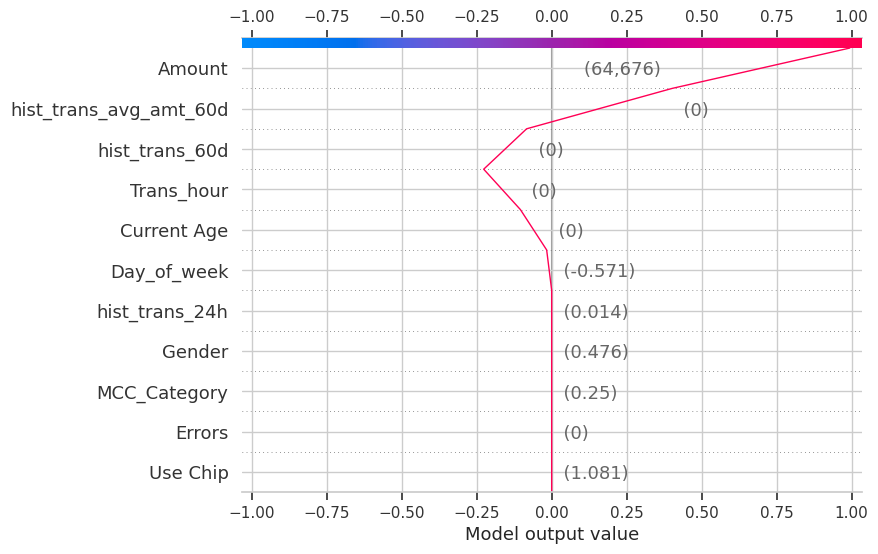

  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


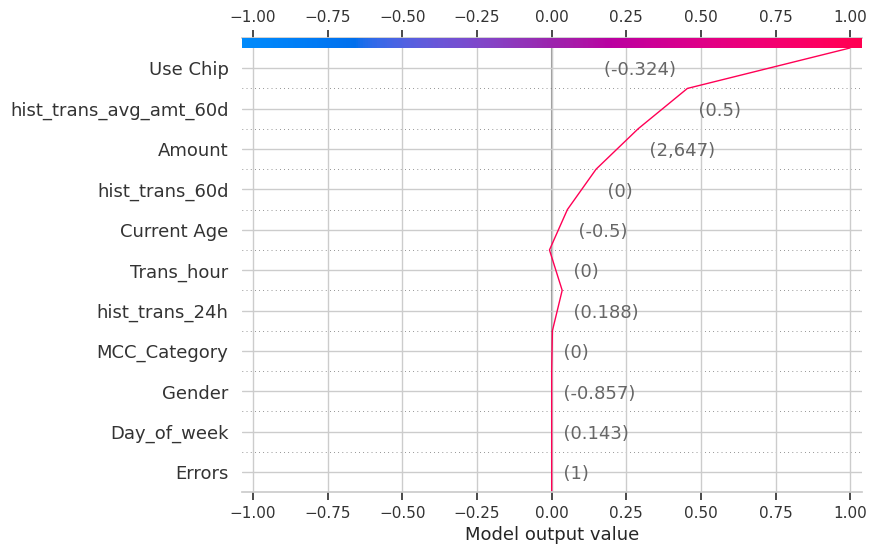

  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 1ms/step


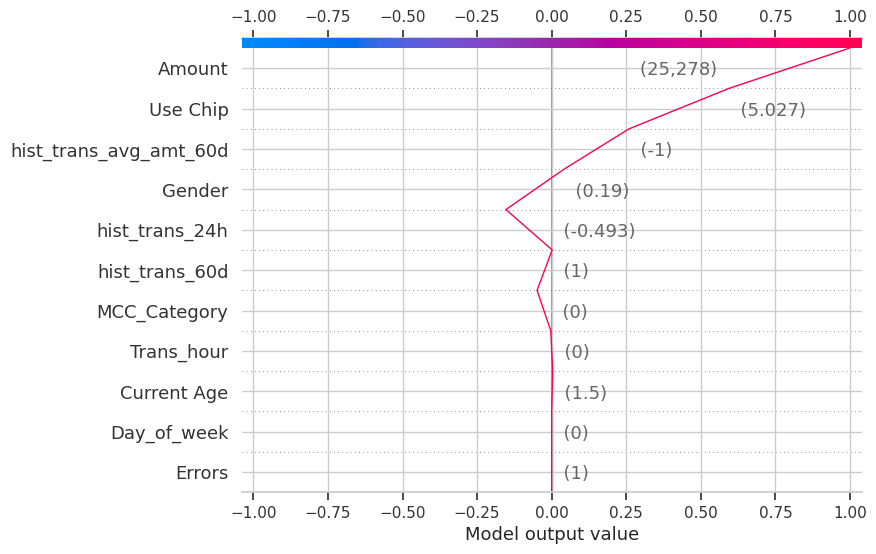

  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


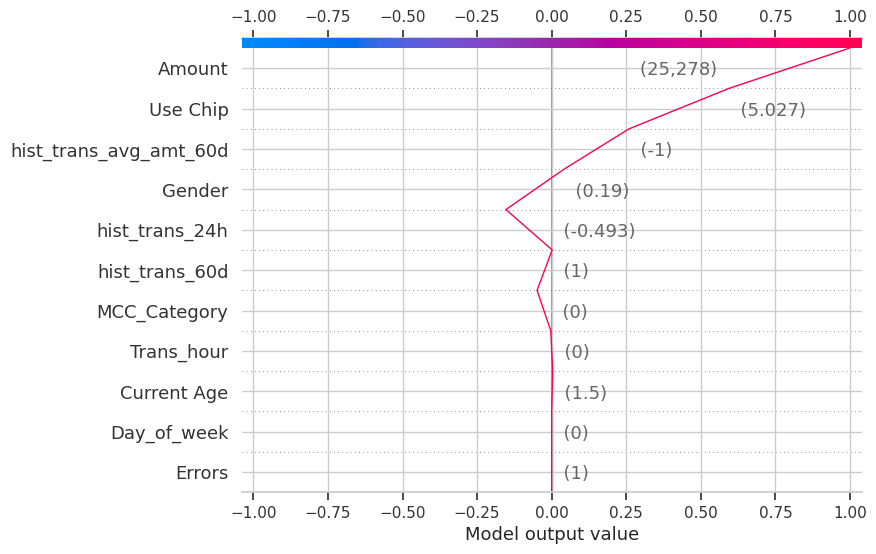

In [ ]:
import shap
import matplotlib.pyplot as plt

def g(record):
    return autoencoder.predict(record)[:, 1]

# Sample background data
DataFrame_features = X_Train.sample(n=6000, random_state=1)
MedianInput = DataFrame_features.median().values.reshape((1, DataFrame_features.shape[1]))

# Get predictions for the test set
y_pred_proba = autoencoder.predict(X_test.iloc[:, 1:])  # Get probabilities
y_pred = (y_pred_proba[:, 1] > 0.5).astype(int)       # Convert to binary predictions

# Filter out instances predicted as fraudulent
fraudulent_indices = np.where(y_pred == 1)[0]

# Choose a subset of fraudulent instances for plotting
# You can adjust the number of plots or choose specific indices
num_plots = 5
selected_indices = np.random.choice(fraudulent_indices, num_plots, replace=False)

# Create SHAP explainer (using KernelExplainer)
explainer = shap.KernelExplainer(g, MedianInput)

# Generate decision plots for the selected instances
for idx in selected_indices:
    instance_to_explain = X_test.iloc[[idx]]
    instance_to_explain_reshaped = instance_to_explain.iloc[:, 1:].values.reshape((1, 11))

    shap_values = explainer.shap_values(instance_to_explain_reshaped)

    shap.decision_plot(
        explainer.expected_value,
        shap_values,
        instance_to_explain,
        feature_names=list(X_Train.columns),
        show=True
    )


# Intergrating LLM API

Install API Dependency

In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.3 MB/s eta 0:00:00


API KEYS (Get yours)

In [ ]:
from openai import OpenAI
client = OpenAI(
    #Paid API provided by https://www.lemonfox.ai/
    #Get your own API Keys
  api_key="Replace_this_text_with_your_keys",
  base_url="https://api.lemonfox.ai/v1",
)

#Generating Narratives

Again, skip all below till Connecting Ngrok


1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


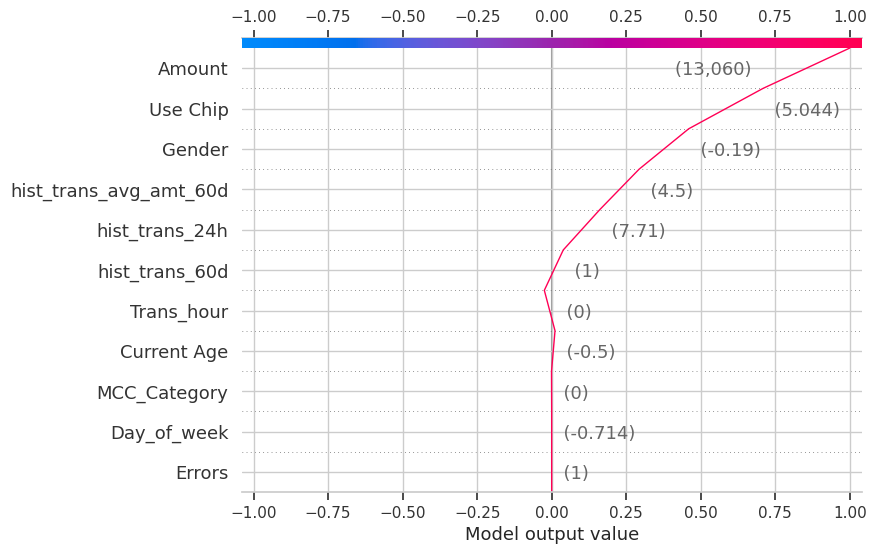




This transaction was flagged because the amount of the transaction is significantly higher than usual, which raises a red flag in our system. Additionally, the fact that you used an online payment method, which is less common, further increased suspicion.


In [ ]:
# Choose a specific instance you want to explain
instance_index = 2508  # Replace with the actual index you want to analyze
instance_to_explain = X_test.iloc[[instance_index]]
instance_to_explain_reshaped = instance_to_explain.iloc[:, 1:].values.reshape((1, 11))

# SHAP explainer (using KernelExplainer for a model-agnostic explanation)
explainer = shap.KernelExplainer(g, MedianInput)

# Calculate SHAP values for the chosen instance
shap_values = explainer.shap_values(instance_to_explain_reshaped)

# Get column names *after* dropping the first column
columns_for_shap = instance_to_explain.columns[1:]  # Exclude the first column
# Create the DataFrame with aligned columns
shap_summary_df = pd.DataFrame(shap_values, columns=columns_for_shap)
# Format as Markdown table
shap_summary_str = shap_summary_df.to_markdown(numalign='left', stralign='left')

shap.decision_plot(
        explainer.expected_value,
        shap_values,
        instance_to_explain,
        feature_names=list(X_Train.columns),
        show=True
    )

prompt_template = """
You are an expert financial analyst. You have been shown SHAP summary plots for a model that detects fraud.
The features of the dataset have been encoded and their corresponding codes are: /start of encode/ MCC Category (which means Type of product purchased): Agricultural Services: 0, Airlines: 1, Automobiles: 2, Banks: 3, Clothing Stores: 4, Contractors: 5, Department Stores: 6, Drug Stores: 7, Eating Places: 8, Furniture: 9, Government: 10, Grocery: 11, Hardware: 12, Hotels: 13, | Errors: No Errors: 0, Having Any Technical Errors: 1 | Gender: Female: 0, Male: 1 | Use Chip: Swipe: 0, Online: 1 /end of encode/
However a robustscaler was used to transform the encoded dataset into used to transform into float64.

**SHAP Summary Table:**
{shap_summary_table}

Explain to a customer why this transaction is marked as fraud in 2 sentences (max). Focus on the most impactful factors and avoid mentioning age or gender.

Additional Information:
* Chip online means online payment - the type mostly done via a web browser.
"""

prompt = prompt_template.format(shap_summary_table=shap_summary_str)
completion = client.chat.completions.create(
  messages = [
    {"role": "system", "content": prompt},
    {"role": "user", "content": "Your response should sound just like this: This transaction was flagged because you've had a high number of transactions in the past 60 days, which raises a red flag in our system. Additionally, the transaction occurred at an unusual hour, further increasing suspicion."}
    ],
  model="llama-70b-chat",
  )
print("\n\n")
print(completion.choices[0].message.content)

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step





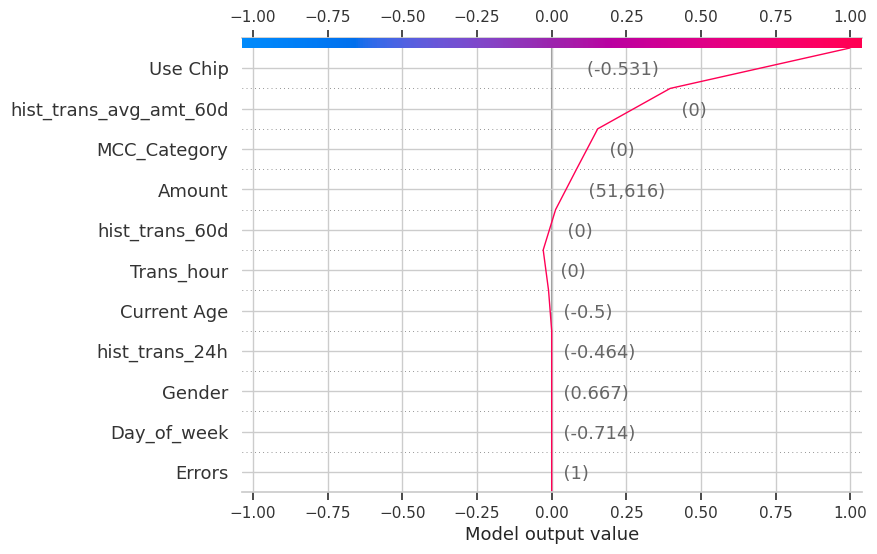



Explanation for instance 36647 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. hist_trans_avg_amt_60d (average amount spent within 60 days) with a SHAP value of 0.242317
2. Use Chip (online payment) with a SHAP value of 0.601182
3. Amount with a SHAP value of 0.0699773

Here's a concise explanation to the customer:

"This transaction was flagged due to an unusually high amount spent online, which differs from your usual spending patterns for this type of product, and is also higher than your average online transactions."



1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step





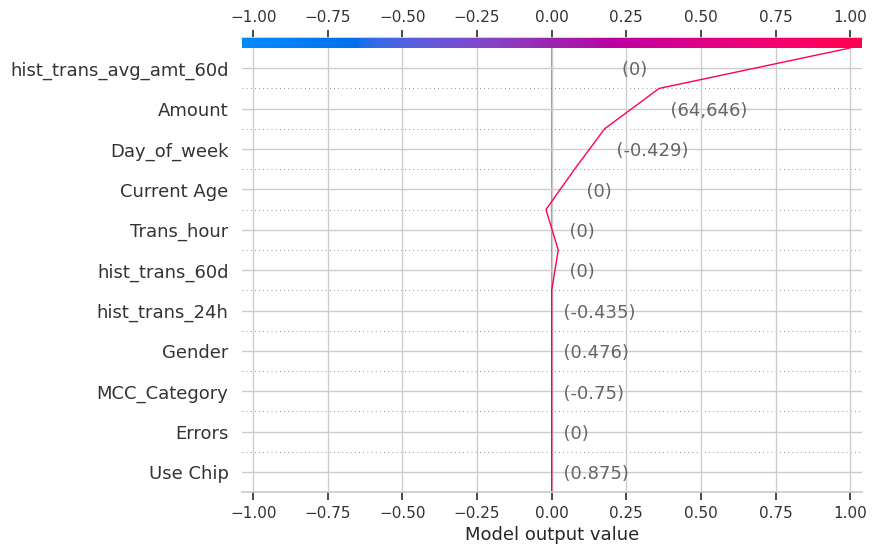



Explanation for instance 17315 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. Average amount spent within 60 days (0.638808)
2. Amount of this transaction (0.182653)
3. Time of day (Trans_hour) (-0.0411926)

Here's a concise explanation for the customer:

"This transaction was flagged due to the unusually high amount spent, which is different from your usual spending patterns for this type of product, and the fact that it occurred at an unusual time of day."



1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step





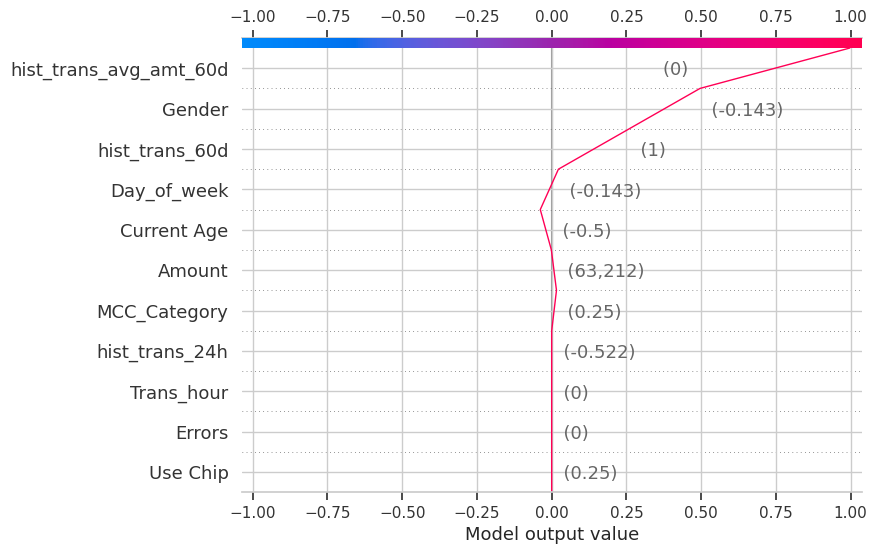



Explanation for instance 39322 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. hist_trans_avg_amt_60d (average amount spent within 60 days) with a SHAP value of 0.500929
2. Gender with a SHAP value of 0.236835
3. hist_trans_60d (number of transactions within 60 days) with a SHAP value of 0.236797

Here's a concise explanation to the customer:

"This transaction was flagged due to an unusually high average spending amount for this type of product over the past 60 days, which differs from your usual spending patterns, and an unusual number of transactions in the past 60 days, which is not typical of your behavior."



1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step





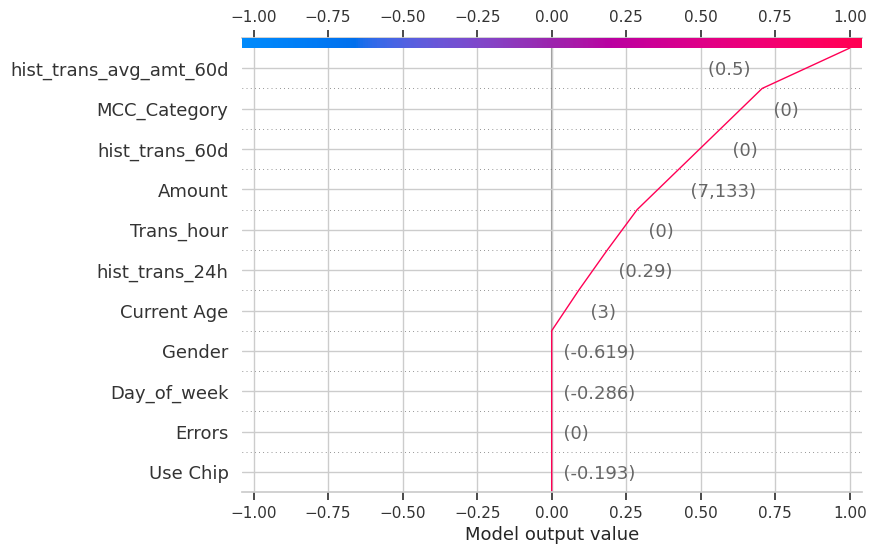



Explanation for instance 10185 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. The average amount spent within 60 days (0.293763)
2. The type of product purchased (MCC Category) (0.139753)
3. The amount of the transaction (0.139741)

Here's a concise explanation to the customer:

"This transaction was flagged due to an unusually high amount spent compared to your usual spending patterns for this type of product, and it's also a larger transaction than usual. Additionally, the type of product purchased is not typical for you."



1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step





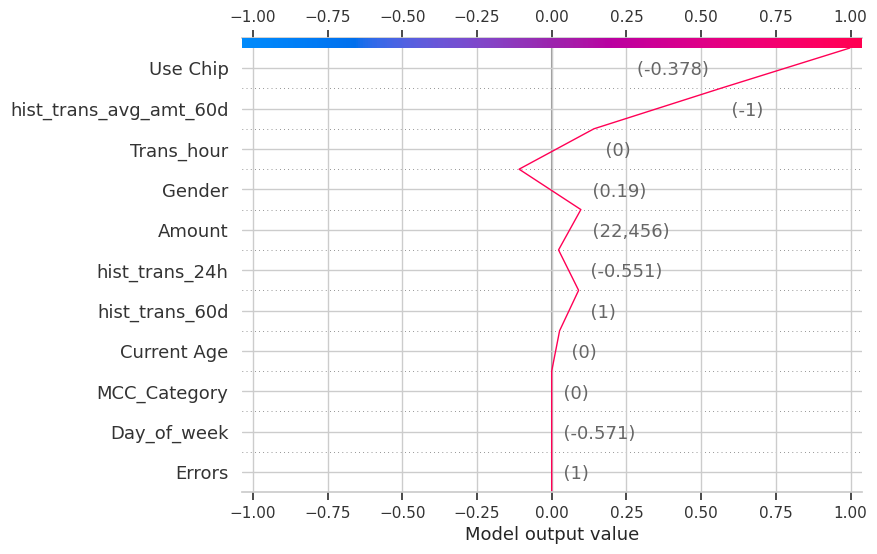



Explanation for instance 40241 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. hist_trans_avg_amt_60d (average amount spent within 60 days) with a SHAP value of 0.423164
2. Use Chip (online payment) with a SHAP value of 0.433066
3. Amount with a SHAP value of 0.0746881

Here's a concise explanation to the customer:

"This transaction was flagged due to an unusually high amount spent online, which differs from your usual spending patterns for this type of product, and is also higher than your average online transaction amount."



1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step





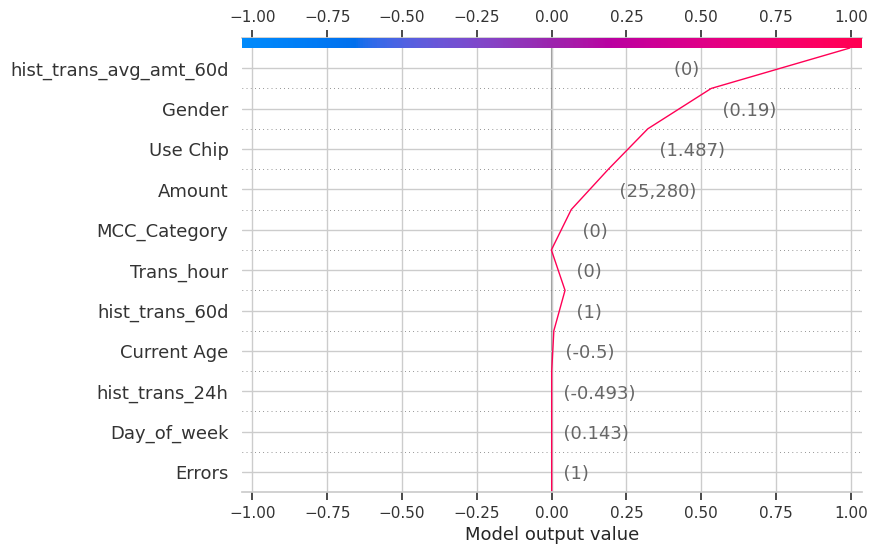



Explanation for instance 12494 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. hist_trans_avg_amt_60d (average amount spent within 60 days) with a SHAP value of 0.463028
2. Amount with a SHAP value of 0.124157
3. Gender with a SHAP value of 0.211943

Here's a concise explanation to the customer:

"This transaction was flagged due to an unusually high amount spent compared to your usual spending patterns for this type of product, combined with a larger-than-normal transaction amount and a difference in your typical payment behavior."



1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 0s 1ms/step





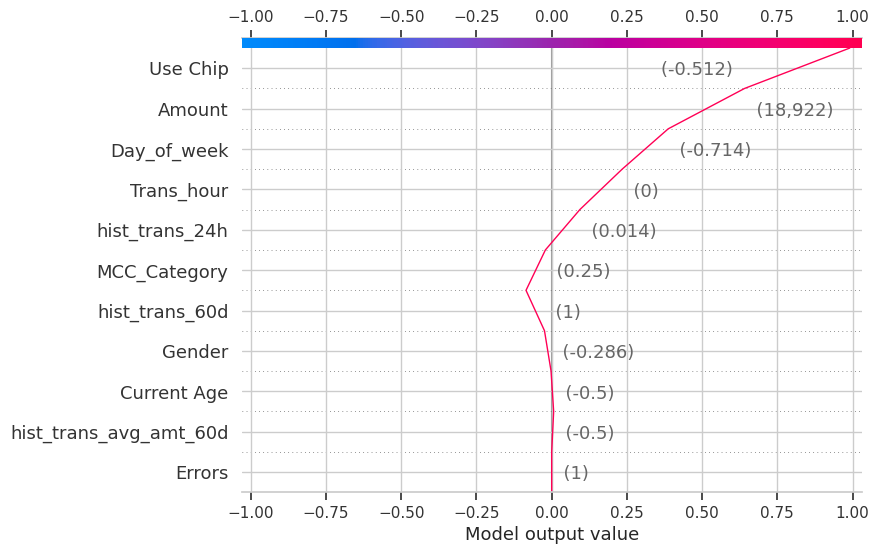



Explanation for instance 3626 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. Amount (0.25386): The transaction amount is unusually high compared to the customer's typical spending patterns.
2. Use Chip (0.349593): The transaction was made online, which is unusual for this customer.
3. hist_trans_24h (0.114627): There have been an unusual number of transactions within the past 24 hours.

Here's a concise explanation to the customer:

"This transaction was flagged due to its unusually high amount, the fact that it was made online (which is not typical for you), and the high number of transactions you've made in the past 24 hours, which differs from your usual spending patterns."



1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step





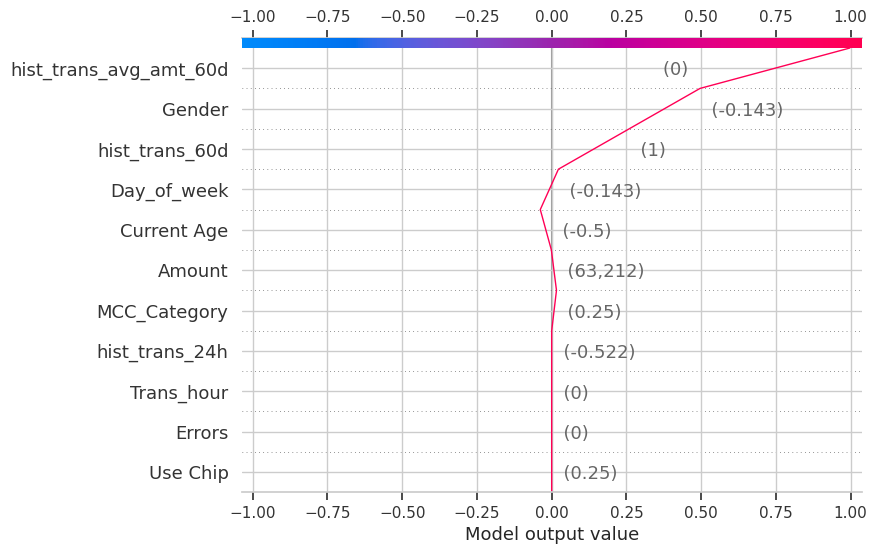



Explanation for instance 16377 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. hist_trans_avg_amt_60d (average amount spent within 60 days) with a SHAP value of 0.500929
2. Gender with a SHAP value of 0.236835
3. hist_trans_60d (number of transactions within 60 days) with a SHAP value of 0.236797

Here's a concise explanation to the customer:

"This transaction was flagged due to an unusually high average spending amount for this type of product over the past 60 days, which differs from your usual spending patterns, and an unusual number of transactions in the past 60 days, which is not typical of your behavior."



1/1 [==============================] - 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step





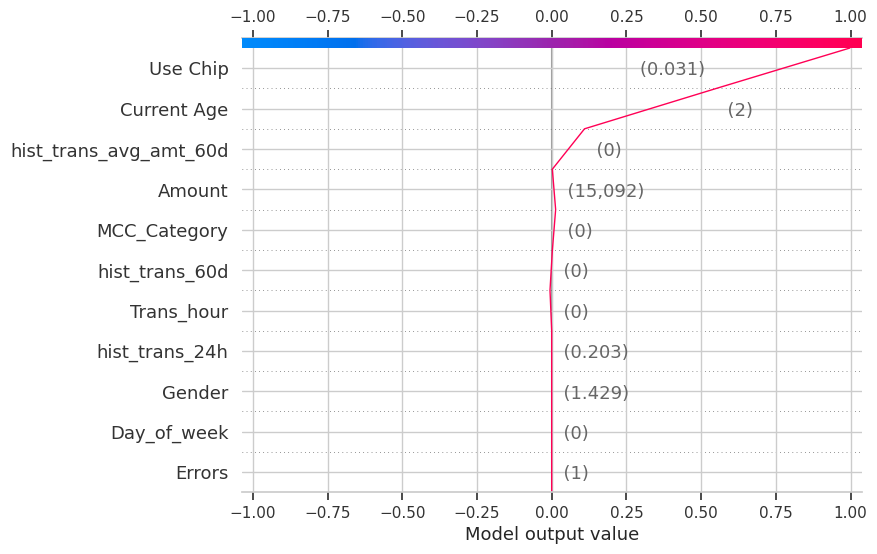



Explanation for instance 13483 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. Use Chip (Online payment): 0.446608 (high value)
2. Current Age: 0.440979 (high value)
3. hist_trans_avg_amt_60d (average amount spent within 60 days): 0.107702 (high value)

Here's a concise explanation for the customer:

"This transaction was flagged due to an unusual online payment, which is not typical of your usual spending habits, combined with a higher-than-average amount spent recently on this type of product, and some differences in your recent transaction history."



1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step





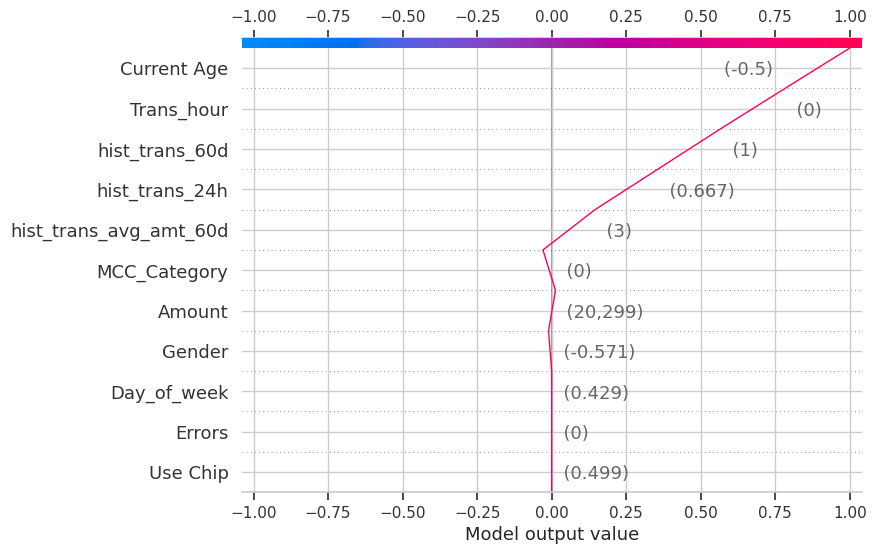



Explanation for instance 21715 :
Based on the SHAP values, the top 3 features that most strongly indicate fraudulent activity are:

1. Trans_hour (0.216055): This transaction was made at an unusual time of day compared to your typical transactions.
2. hist_trans_60d (0.210432) and hist_trans_24h (0.210432): You've made an unusually high number of transactions in the past 24 hours and 60 days.

Here's a concise explanation for the customer:

"This transaction was flagged due to its unusual timing and the high number of recent transactions, which differ from your usual spending patterns for this type of product."





In [ ]:
# Get probabilities
y_pred_proba = autoencoder.predict(X_test.iloc[:, 1:])
# Convert to binary predictions
y_pred = (y_pred_proba[:, 1] > 0.5).astype(int)

# Filter out instances predicted as fraudulent
fraudulent_indices = np.where(y_pred == 1)[0]

# Choose random indices to explain
num_samples = 10
selected_indices = np.random.choice(fraudulent_indices, num_samples, replace=True)

for instance_index in selected_indices:
    # Get the specific instance
    instance_to_explain = X_test.iloc[[instance_index]]
    instance_to_explain_reshaped = instance_to_explain.iloc[:, 1:].values.reshape((1, 11))

    # SHAP explainer
    explainer = shap.KernelExplainer(g, MedianInput)

    # Calculate SHAP values
    shap_values = explainer.shap_values(instance_to_explain_reshaped)

     # Show SHAP decision plot
    print("\n\n")
    shap.decision_plot(
        explainer.expected_value,
        shap_values,
        instance_to_explain,
        feature_names=list(X_Train.columns),
        show=True
    )

    # Get column names
    columns_for_shap = instance_to_explain.columns[1:]

    # Create the DataFrame
    shap_summary_df = pd.DataFrame(shap_values, columns=columns_for_shap)

    # Format the DataFrame as a markdown table
    shap_summary_str = shap_summary_df.to_markdown(numalign='left', stralign='left')

    prompt_template = """
    You are an expert financial analyst specializing in fraud detection. You have been shown SHAP summary plots for a model that identifies fraudulent transactions.

    The features of the dataset have been encoded and their corresponding codes are:
    /start of encode/
    MCC Category (which means Type of product purchased) |
    Errors; No Errors: 0, Insufficient balance: 1, Incorrect card details: 2, Incorrenct card details: 3, Having Any Technical Errors:>=4 |
    Gender: Female: 0, Male: 1 |
    Use Chip: Swipe: 0, Online: 1
    /end of encode/

    **SHAP Summary Table:**
    {shap_summary_table}

    Analyze the SHAP values for this transaction and identify the top 2-3 features that most strongly indicate fraudulent activity. Then, write a concise, one-sentence explanation to a customer highlighting why this transaction was flagged as potentially fraudulent.

    Be sure to:

    Focus on the specific values of the most impactful features.** Explain *how* these values differ from the customer's usual behavior or typical transaction patterns. Use phrases like "This transaction was flagged due to..." followed by a description of the unusual feature values.
    Avoid mentioning sensitive information such as age or gender.
    Use clear and concise language that an 8th grader could easily understand.

    Additional Information:
    'Use Chip: Online' means the transaction is an online payment.
    'hist_trans_24' means the number of transactions within 24 hours.
    'hist_trans_60' means the number of transactions within 60 days.
    'hist_trans_amt_avg_60d' means the average amount spent within 60 days.
    When talking about average transactions, use phrases like "This transaction differs from your usual spending patterns for this type of product."
    Do not directly mention feature names; instead, describe their meaning in layman's terms.
    """

    prompt = prompt_template.format(shap_summary_table=shap_summary_str)
    completion = client.chat.completions.create(
      messages = [
      {"role": "system", "content": prompt},
      {"role": "user", "content": "Your response should be concise, easy to undestand by an 8th grader."}
      ],
      model="llama-70b-chat",
      )

    print("\n")
    print("Explanation for instance", instance_index, ":")  # Label the output
    print(completion.choices[0].message.content)
    print("\n\n")



1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


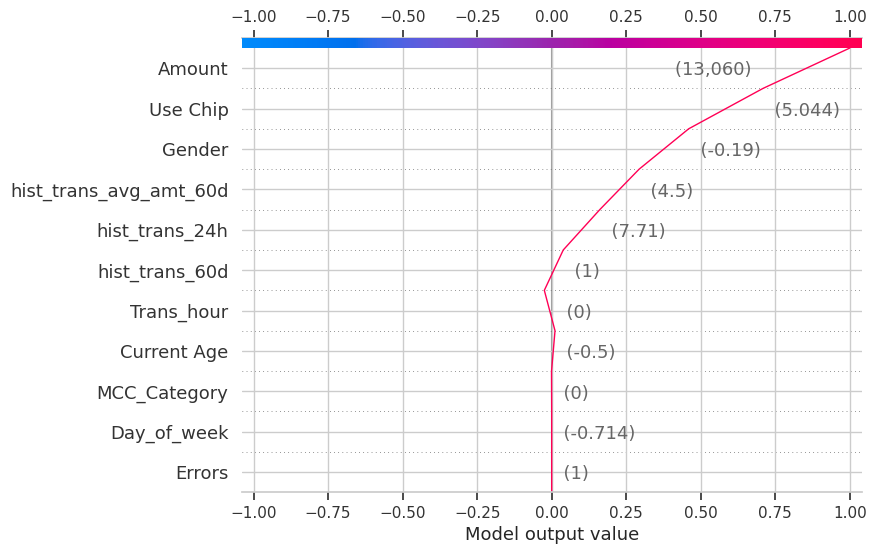




Imagine you were on a late-night online shopping spree, buying a bunch of stuff from a clothing store using your credit card, and the transaction failed & you got an email from your bank stating it was blocked due to fraud.

This transaction was flagged because you've had a high number of transactions in the past 60 days, which raises a red flag in our system. Additionally, the transaction occurred through an online payment method, which is a higher-risk channel, further increasing suspicion.


In [ ]:
# Choose a specific instance you want to explain
instance_index = 2508  # Replace with the actual index you want to analyze
instance_to_explain = X_test.iloc[[instance_index]]
instance_to_explain_reshaped = instance_to_explain.iloc[:, 1:].values.reshape((1, 11))

# SHAP explainer (using KernelExplainer for a model-agnostic explanation)
explainer = shap.KernelExplainer(g, MedianInput)

# Calculate SHAP values for the chosen instance
shap_values = explainer.shap_values(instance_to_explain_reshaped)

# Get column names *after* dropping the first column
columns_for_shap = instance_to_explain.columns[1:]  # Exclude the first column
# Create the DataFrame with aligned columns
shap_summary_df = pd.DataFrame(shap_values, columns=columns_for_shap)
# Format as Markdown table
shap_summary_str = shap_summary_df.to_markdown(numalign='left', stralign='left')

shap.decision_plot(
        explainer.expected_value,
        shap_values,
        instance_to_explain,
        feature_names=list(X_Train.columns),
        show=True
    )

prompt_template = """
You are an expert financial analyst. You have been shown SHAP summary plots for a model that detects fraud.
The features of the dataset have been encoded and their corresponding codes are: /start of encode/ MCC Category (which means Type of product purchased): Agricultural Services: 0, Airlines: 1, Automobiles: 2, Banks: 3, Clothing Stores: 4, Contractors: 5, Department Stores: 6, Drug Stores: 7, Eating Places: 8, Furniture: 9, Government: 10, Grocery: 11, Hardware: 12, Hotels: 13, | Errors: No Errors: 0, Having Any Technical Errors: 1 | Gender: Female: 0, Male: 1 | Use Chip: Swipe: 0, Online: 1 /end of encode/
However a robustscaler was used to transform the encoded dataset into used to transform into float64.

**SHAP Summary Table:**
{shap_summary_table}

Explain to a customer why this transaction is marked as fraud in 2 sentences (max). Focus on the most impactful factors and avoid mentioning age or gender.

Additional Information:
* Chip online means online payment - the type mostly done via a web browser.
"""

prompt = prompt_template.format(shap_summary_table=shap_summary_str)
completion = client.chat.completions.create(
  messages = [
    {"role": "system", "content": prompt},
    {"role": "user", "content": "Your response should sound just like this: This transaction was flagged because you've had a high number of transactions in the past 60 days, which raises a red flag in our system. Additionally, the transaction occurred at an unusual hour, further increasing suspicion."},
    {"role": "user", "content": "Before your repsonse for the SHAP summary table, write a one sentence scenario that would match the situation in which that transcation could occur. This should be narrative - starting with the pharse; Imagine you... End it with, the transcation failed & you got an email from your bank stating it was blocked due to fraud"}
    ],
  model="llama-70b-chat",
  )
print("\n\n")
print(completion.choices[0].message.content)

# Connecting Ngrok

In [ ]:
!pip install --upgrade pyngrok

In [ ]:
from pyngrok import ngrok, conf

!ngrok config check

Valid configuration file at /root/.config/ngrok/ngrok.yml


If you want a persistent ngrok free link using edges; copy the start a tunnel from a config file in your dashboard into a yml file (save a txt file as ngrok.yml) upload to the root folder of your filesystem then run the code below

In [ ]:
# Copy the ngrok.yml file to the root directory
# Feel free to change the location of your created yml file (mine is /ngrok.yml), but leave the /root/.config/ngrok. Also there's a space in between the two file directories :)

!sudo cp /ngrok.yml /root/.config/ngrok/

^C


In [ ]:
from flask import Flask, render_template, request, jsonify, Markup
from pyngrok import ngrok, conf
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import subprocess
import threading
import random

# Get your own ngrok AUTH KEY!
ngrok.set_auth_token("Replace_this_text_with_your_keys")

# Set Flask app
#App interaface file loaction, edit the HTML if you so desire just make sure it's in that location - unless, no dice for you :)
app = Flask(__name__, template_folder='/usr/local/lib/python3.10/dist-packages/flask/templates')

def format_llm_output(text):
    paragraphs = text.split('\n')
    formatted_text = "<br>".join(paragraphs)
    return Markup(formatted_text)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/generate', methods=['POST'])
def generate():
    # Sample background data (optional for decision plot, but useful for reference)
    DataFrame_features = X_Train.sample(n=6000, random_state=1)
    MedianInput = DataFrame_features.median().values.reshape((1, DataFrame_features.shape[1]))

    # Get probabilities
    y_pred_proba = autoencoder.predict(X_test.iloc[:, 1:])
    # Convert to binary predictions
    y_pred = (y_pred_proba[:, 1] > 0.5).astype(int)
    # Filter out instances predicted as fraudulent
    fraudulent_indices = np.where(y_pred == 1)[0]

    # Choose a random index to explain
    selected_index = random.choice(fraudulent_indices)
    # Get the specific instance and reshape it
    instance_to_explain = X_test.iloc[[selected_index]]
    instance_to_explain_reshaped = instance_to_explain.iloc[:, 1:].values.reshape((1, 11))

    # SHAP explainer
    explainer = shap.KernelExplainer(g, MedianInput)
    shap_values = explainer.shap_values(instance_to_explain_reshaped)

    # Generate SHAP plot
    fig = plt.figure()
    shap.decision_plot(explainer.expected_value, shap_values, instance_to_explain, feature_names=list(X_Train.columns), show=False)

    buffer = BytesIO()
    fig.savefig(buffer, format='png')
    buffer.seek(0)
    shap_plot_b64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    plt.close(fig)

    # Create the SHAP summary DataFrame
    columns_for_shap = instance_to_explain.columns[1:]
    shap_summary_df = pd.DataFrame(shap_values, columns=columns_for_shap)
    shap_summary_str = shap_summary_df.to_markdown(numalign='left', stralign='left')

    # Prepare LLM prompt and get explanation
    prompt_template = """
    You are an expert financial analyst specializing in fraud detection. You have been shown SHAP summary plots for a model that identifies fraudulent transactions.

    The features of the dataset have been encoded and their corresponding codes are:
    /start of encode/
    MCC Category (which means Type of product purchased) |
    Errors; No Errors: 0, Insufficient balance: 1, Incorrect card details: 2, Incorrenct card details: 3, Having Any Technical Errors:>=4 |
    Gender: Female: 0, Male: 1 |
    Use Chip: Swipe: 0, Online: 1
    /end of encode/

    **SHAP Summary Table:**
    {shap_summary_table}

    Analyze the SHAP values for this transaction and identify the top 2-3 features that most strongly indicate fraudulent activity. Then, write a concise, one-sentence explanation to a customer highlighting why this transaction was flagged as potentially fraudulent.

    Be sure to:

    Focus on the specific values of the most impactful features.** Explain *how* these values differ from the customer's usual behavior or typical transaction patterns. Use phrases like "This transaction was flagged due to..." followed by a description of the unusual feature values.
    Avoid mentioning sensitive information such as age or gender.
    Use clear and concise language that an 8th grader could easily understand.

    Additional Information:
    'Use Chip: Online' means the transaction is an online payment.
    'hist_trans_24' means the number of transactions within 24 hours.
    'hist_trans_60' means the number of transactions within 60 days.
    'hist_trans_amt_avg_60d' means the average amount spent within 60 days.
    When talking about average transactions, use phrases like "This transaction differs from your usual spending patterns for this type of product."
    Do not directly mention feature names; instead, describe their meaning in layman's terms.
    """

    prompt = prompt_template.format(shap_summary_table=shap_summary_str)
    completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": "Your response should be concise, easy to understand by an 8th grader."}
        ],
        model="llama-70b-chat",
    )

    llm_explanation = format_llm_output(completion.choices[0].message.content)

    return jsonify({
        'shap_plot': shap_plot_b64,
        'llm_explanation': llm_explanation,
        'instance_index': int(selected_index)  # Convert to regular Python integer
    })

@app.route('/submit', methods=['POST'])
def submit():
    instance_index = request.form.get('instance_index')
    understandability = request.form.get('understandability')

    if understandability:
        with open('/responses.txt', 'a') as f:
            f.write(f"Instance Index: {instance_index}, Understandability: {understandability}\n")

    return jsonify({'status': 'success'})

def run_flask_app():
    port = 5000
    app.run(host='0.0.0.0', port=port)

def start_ngrok_tunnel():
    subprocess.run('ngrok start XAI', shell=True)

if __name__ == '__main__':
    # Start Flask app in a separate thread
    flask_thread = threading.Thread(target=run_flask_app)
    flask_thread.start()

    # Start ngrok in the main thread
    start_ngrok_tunnel()

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 07:59:19] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 07:59:20] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 73ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 07:59:25] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 07:59:28] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 07:59:28] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 07:59:34] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:03:46] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:03:46] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:03:52] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:04:34] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:04:39] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:05:34] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:07:19] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:07:20] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:07:28] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:08:04] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:08:17] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:08:32] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:11:20] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:11:21] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:11:30] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:11:50] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:11:59] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:15:46] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:15:55] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:16:53] "GET / HTTP/1.1" 200 -


 800/1279 [=================>............] - ETA: 0s

INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:16:56] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:16:59] "POST /generate HTTP/1.1" 200 -


 513/1279 [===========>..................] - ETA: 1s

INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:17:02] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:17:06] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:17:22] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:17:30] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:24:23] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:24:23] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:24:37] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:24:43] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:25:17] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:25:24] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:25:47] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:25:53] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:25:55] "POST /generate HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:26:02] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:26:10] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:26:17] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:26:35] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:40:43] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:53:49] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:53:49] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:54:15] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:54:34] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:54:34] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:54:57] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:54:57] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:55:20] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:55:24] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:55:33] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:55:36] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:55:37] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:55:38] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:55:46] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:55:47] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:56:05] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 08:56:11] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:12:40] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:12:40] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:12:54] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:13:24] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:26:24] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:26:25] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:26:38] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:27:11] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:27:21] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:36:19] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:58:36] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:58:37] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:58:46] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:59:11] "POST /submit HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 09:59:19] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 10:58:00] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 10:58:06] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 10:58:12] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 11:26:48] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 12:14:32] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 12:14:34] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 13:26:43] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 13:26:44] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 13:27:14] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 13:27:22] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 13:29:11] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 13:42:51] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 13:43:01] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 13:43:30] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 14:39:18] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 14:39:18] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 14:39:25] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 14:39:34] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 15:35:32] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 18:38:29] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 18:38:29] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 19:16:10] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 1ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 19:16:16] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 20:24:30] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 20:24:30] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 20:56:50] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 20:56:58] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 21:49:20] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 21:49:25] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 21:49:25] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 21:49:56] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 21:50:25] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 21:50:52] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 21:56:42] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jun/2024 21:56:47] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jun/2024 08:41:09] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Jun/2024 10:56:35] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jun/2024 06:05:13] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jun/2024 06:05:13] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jun/2024 10:53:57] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jun/2024 10:53:58] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [30/Jun/2024 17:35:39] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jun/2024 17:35:46] "GET /responses.txt HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [01/Jul/2024 19:01:42] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 08:28:52] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 08:28:59] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 10:24:28] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:06:20] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:37:19] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [04/Jul/2024 09:59:39] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [04/Jul/2024 09:59:41] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2024 08:14:44] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2024 08:14:44] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


INFO:werkzeug:127.0.0.1 - - [09/Jul/2024 08:15:01] "POST /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2024 08:15:45] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2024 15:04:12] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2024 20:06:29] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2024 20:06:29] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [09/Jul/2024 20:06:31] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Jul/2024 14:58:48] "GET /apple-touch-icon-120x120-precomposed.png HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Jul/2024 14:58:48] "GET /apple-touch-icon-120x120.png HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Jul/2024 14:58:48] "GET /apple-touch-icon-precomposed.png HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Jul/2024 14:58:48] "GET /apple-touch-icon.png HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Jul/2024 14:58:49] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127